<a href="https://colab.research.google.com/github/diegorusso/deep-learning-from-scratch/blob/master/07_dropout_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout

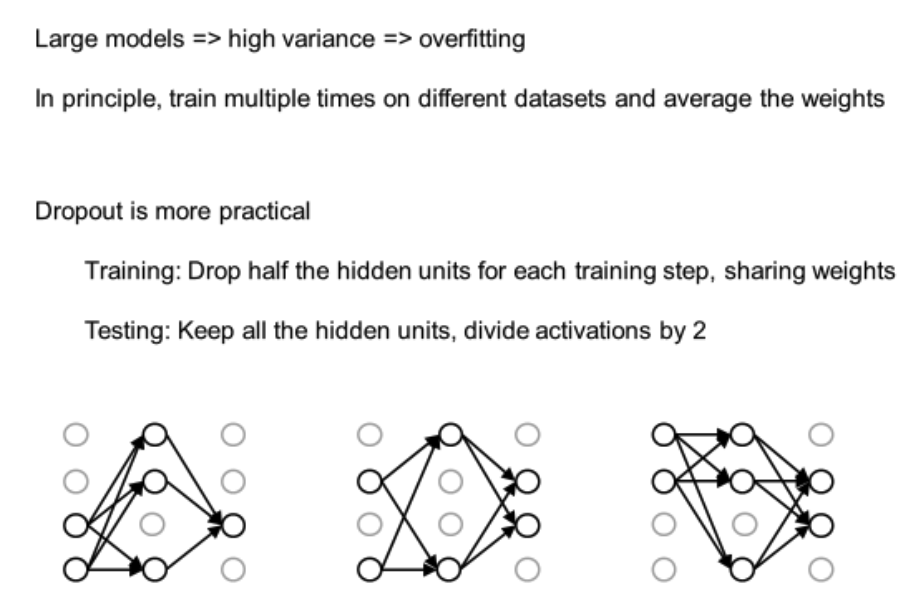



The idea of dropout is to drop half the hidden units (or some other fraction) for each training step, maintaining the same set of weights even though a subset of the units are dropped.

The effect of this is to train a different network with every data sample, combining the results because all these sub-networks share a common set of weights.

Intuitively, it means that each unit has to contribute to predicting the correct output regardless of which particular set of units it is connected to in the previous layer.

For testing and deployment, dropout is removed and all the units are connected back into the network. With dropout removed, the fanin of each unit is doubled (or increased by some other factor, depending on the proportion of units dropped), so the values of the activations have to be decreased by the same factor.

With dropout you are effectively training a different network at each training step. Because of this, the accuracy achieved for each individual epoch (one pass through the entire training dataset) is usually lower than for the equivalent network without dropout

Dropout is a popular regularization technique but it does not work for all networks

Large amounts of dropout are typically applied only to fully-connected layers because such layers can afford to lose units


# Batch Normalization

It is important to normalise data that is to apply a transformation to the dataset so that it has **mean = 0 and standard deviation = 1**.

Each layer in the network can benefir if the data coming into that layer is normalized.

Going even further, each layer can benefit if the data within each individual mini-batch is normalized, since each gradient descent step depends on the data in one specific mini-batch.

We want to make sure that the data in each mini-batch is normalized at every step of the forward pass that might benefit from normalization, most notably any non-linear activation functions in the network.

We want to keep the data in the interesting region of the non-linearity, not in the saturated region. **This is batch normalization**.

Batch norm is not related to Dropout but they can be used together in the same network.

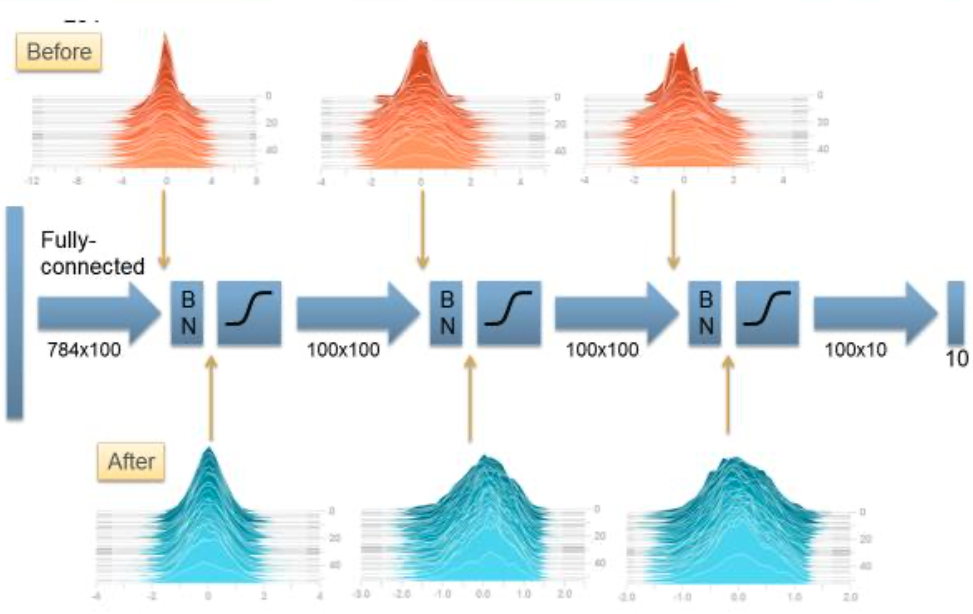

The image above shows the distribution of activations before and after each batch normalization layer. You can see the widths of the distributions being changed significantly by the leftmost and by the rightmost batch normalization layers in the network.

The overall effect of batch normalization is to scale-and-shift the distribution of values coming into each non-linear activation function. The goal is to keep the values in the interesting part of the activation function to avoid vanishing gradients.

Whether the activation function is a sigmoid or a RELU, it is important to shift the distribution so that it is **centered on the non-linearity**.

This is not so when it comes to the **scale of the distribution**, however. For a RELU, so long as the distribution is centred around the kink in the curve, the scale is irrelevant.

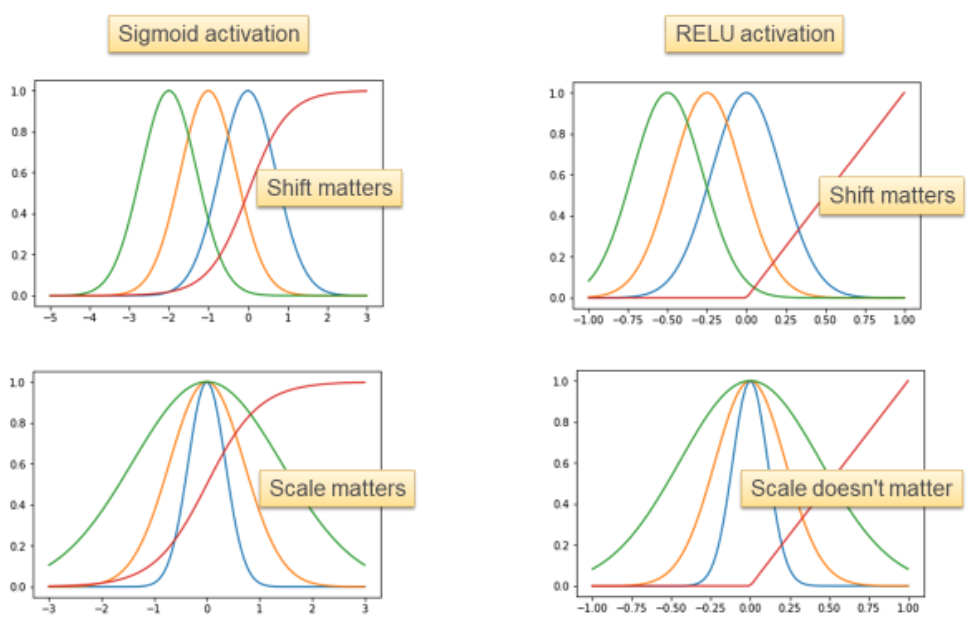


Let's see how we can implement both Dropout and Batch Nomralization in Tensorflor. The following code will run 4 trainings:
1. No optimiziations
2. Dropout only
3. Batch normalization only 
4. Both dropout and batch normalization

We are using a simple CNN and the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which is described in detail in the paper [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky, 2009.

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60,000 32x32 pixel colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

NOTE: **the run could take several minutes to run. Try to change the runtime to use a GPU. It will speed up the training.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.utils  import to_categorical
from tensorflow.keras.backend  import clear_session

def build_and_run_model(dropout = 0, bn = False):
    
    # Ensure a clean start
    clear_session()

    # The data, shuffled and split between train and test sets:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    n_labels = 10

    # Convert class vectors to binary class matrices.
    y_train = to_categorical(y_train, n_labels)
    y_test = to_categorical(y_test, n_labels)

    # Normalize the images to have zero mean and values in range [-1,+1]
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255
    mean    = x_train.mean()
    x_train = x_train - mean
    x_test  = x_test - mean

    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], use_bias=(not bn)))
    if bn: model.add(BatchNormalization(scale=False)) # NOTE: scale is not relevant with ReLU
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3), padding='same', use_bias=(not bn)))
    if bn: model.add(BatchNormalization(scale=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same', use_bias=(not bn)))
    if bn: model.add(BatchNormalization(scale=False))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), use_bias=(not bn)))
    if bn: model.add(BatchNormalization(scale=False))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if dropout: model.add(Dropout(dropout)) # We add the Dropout

    model.add(Flatten())
    model.add(Dense(512, use_bias=(not bn)))
    if bn: model.add(BatchNormalization(scale=False))
    model.add(Activation('relu'))
    if dropout: model.add(Dropout(dropout))
        
    model.add(Dense(n_labels))
    model.add(Activation('softmax'))
    model.summary()

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(x_train, y_train, 
              batch_size=32, epochs=10,
              validation_data=(x_test, y_test), shuffle=True);

print('\nNo optimizations')
build_and_run_model(dropout = 0,  bn = False)

print('\nDropout only')
build_and_run_model(dropout = 0.5,  bn = False)

print('\nBatch normalization only')
build_and_run_model(dropout = 0, bn = True)

print('\nBoth dropout and batch normalization')
build_and_run_model(dropout = 0.5,  bn = True)


No optimizations
170500096/170498071 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_____________________________________